### Importing the Data

In [1]:
library(data.table)
library(ggplot2)
train_dt <- fread("C:/Users/kaan9/OneDrive/Masaüstü/IE440Final21Training.txt")
colnames(train_dt) <- c("x","y")
test_dt <- fread("C:/Users/kaan9/OneDrive/Masaüstü/IE440Final21Test.txt")
colnames(test_dt) <- c("x","y")
head(train_dt)
options(repr.plot.width=6, repr.plot.height=6)

x,y
<dbl>,<dbl>
202.2445,205.9120
246.0861,131.7401
217.7339,154.8883
207.7652,209.4287
247.5324,203.2680
248.2110,186.0544


### Defining Error Functions

While defining the functions, the x and y values of the data is minimised with the division all data points by minimum value. This is neceassary because with the normal data, some matrix values are getting too big to compute.

In [2]:
x <- train_dt$x 
y <- train_dt$y 

x_test <- test_dt$x
y_test <- test_dt$y

objective1 <- expression(
  (y-w0-w1*x)^2
)

objective1_test <- expression(
  (y_test-w0-w1*x_test)^2
)

objective2 <- expression(
  (y-w0-w1*x-w2*x^2-w3*x^3)^2
)

objective2_test <- expression(
  (y_test-w0-w1*x_test-w2*x_test^2-w3*x_test^3)^2
)

### Necessary Functions

The "norm_vec" function calculates the norm of a given vector

In [3]:
norm_vec <- function(vec){
  sqrt(sum(vec^2))
}

The "get_hessian" function calculates the Hessian matrix of a given funciton

In [4]:
get_hessian <- function(exprs,wk,y_values,x_values){
  wk0 <- wk[1]
  wk1 <- wk[2]
  h1 <- sum(eval(D(D(exprs,"w0"),"w0"),envir=list(w0=wk0,w1=wk1)))
  h2 <- sum(eval(D(D(exprs,"w0"),"w1"),envir=list(w0=wk0,w1=wk1)))
  h3 <- sum(eval(D(D(exprs,"w1"),"w0"),envir=list(w0=wk0,w1=wk1)))
  h4 <- sum(eval(D(D(exprs,"w1"),"w1"),envir=list(w0=wk0,w1=wk1)))
  hes <- matrix(c(h1,h3,h2,h4),nrow=2,ncol=2)
  return(hes)
}

In [5]:
get_hessian_4d <- function(exprs,wk,y_values,x_values){
  wk0 <- wk[1]
  wk1 <- wk[2]
  wk2 <- wk[3]
  wk3 <- wk[4]  
  h1 <- sum(eval(D(D(exprs,"w0"),"w0"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))
  h2 <- sum(eval(D(D(exprs,"w0"),"w1"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))
  h3 <- sum(eval(D(D(exprs,"w0"),"w2"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))
  h4 <- sum(eval(D(D(exprs,"w0"),"w3"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))  
  h5 <- sum(eval(D(D(exprs,"w1"),"w0"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))
  h6 <- sum(eval(D(D(exprs,"w1"),"w1"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))
  h7 <- sum(eval(D(D(exprs,"w1"),"w2"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))
  h8 <- sum(eval(D(D(exprs,"w1"),"w3"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))
  h9 <- sum(eval(D(D(exprs,"w2"),"w0"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))
  h10 <- sum(eval(D(D(exprs,"w2"),"w1"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))
  h11 <- sum(eval(D(D(exprs,"w2"),"w2"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))
  h12 <- sum(eval(D(D(exprs,"w2"),"w3"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))
  h13 <- sum(eval(D(D(exprs,"w3"),"w0"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))
  h14 <- sum(eval(D(D(exprs,"w3"),"w1"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))
  h15 <- sum(eval(D(D(exprs,"w3"),"w2"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))
  h16 <- sum(eval(D(D(exprs,"w3"),"w3"),envir=list(w0=wk0,w1=wk1,w2=wk2,w3=wk3)))  
  hes <- matrix(c(h1,h5,h9,h13,h2,h6,h10,h14,h3,h7,h11,h15,h4,h8,h12,h16),nrow=4,ncol=4)
  return(hes)
}

The "GoldenSectionMethod" function returns minimum of a one dimensional function on a given range from "a" to "b"

In [6]:
GoldenSectionMethod <- function(a,b,e2,func) {
  gamma <- 1.618
  x <- b - (1/gamma)*(b-a)
  y <- a + (1/gamma)*(b-a)
  fx <- func(x)
  fy <- func(y)  
  while (b-a>=e2) {
    if(fx > fy) {
      a <- x
      x <- y
      y <- a + (1/gamma)*(b-a)
      fx <- fy
      fy <- func(y)
    }   
    else {
      b <- y
      y <- x
      x <- b - (1/gamma)*(b-a)
      fy <- fx
      fx <- func(x)
    }
  } 
  return(x)
}

The "argmin" function returns argmin of a given function on a specific direction, with the help of Golden Section Method

In [7]:
argmin <- function(objective,xk,e2,direction){
  
  func <- function(alpha){
    return(objective(xk+(alpha*direction)))
  }
  min <- GoldenSectionMethod(-100,100,e2,func)
  return(min)
}

### 1) Least Square Method

#### a) Linear Regression

Newton's algorithm for the non-linear functions is used for finding the optimum "w" values in the error functions. Shown below is the algortihm for 2-dimensional functions. However,  data is pre-processed in the defined function by dividing to minimum value, because some matrices are getting too big to compute. The final values are multiplied again by the minimum value to find the best sollution.

In [8]:
linearRegression_newton <- function(e1,e2,data,w0){
    
    x_values <- data$x / min(data$x,data$y)
    y_values <- data$y / min(data$x,data$y)

    exprs <- expression(
      (y_values-w0-w1*x_values)^2
    )
  
  objective_st <- function(wvec){
    w0_st <- wvec[1]
    w1_st <- wvec[2]
    return(sum(eval(exprs,envir = list(w0=w0_st,w1=w1_st))))
  }
  k <- 0
  w <- list()
  w[[as.character(k)]] <- w0
  ctrl <- TRUE  
  
  while(ctrl==TRUE){
    hes <- get_hessian(exprs,w[[as.character(k)]],y_values,x_values)
    g1  <- sum(eval(D(exprs,"w0"),envir = list(w0=w[[as.character(k)]][1],w1=w[[as.character(k)]][2])))
    g2  <- sum(eval(D(exprs,"w1"),envir = list(w0=w[[as.character(k)]][1],w1=w[[as.character(k)]][2])))
    grad <- c(-g1,-g2)
    direction <- solve(hes) %*% grad  
    alpha <- argmin(objective_st,w[[as.character(k)]],e2,direction)
    w[[as.character(k+1)]] <- w[[as.character(k)]]+(alpha*direction)
    k <- k + 1
    if(norm_vec(grad)<e1){
      ctrl <- FALSE
    }
  }
  w0 <- w[[length(w)]][1]*min(data$x,data$y)
  w1 <- w[[length(w)]][2]
  it <- length(w)  
  return(data.table("Number of iterations"=it,"w0"=w0,"w1"=w1))
}

In [9]:
res_a <- linearRegression_newton(0.00001,0.00001,train_dt,c(1,1))
res_a

Number of iterations,w0,w1
<int>,<dbl>,<dbl>
11,103.9086,0.7403813


The function found the best "w" parameters after 11 iterations. Best values of "w" parameters are w0=103.90, w1=0.74 So, the linear regression model is y=103.90+(0.74*x). The results could be compared to the R's "lm" function.

In [10]:
model_lm <- lm(y~x,train_dt)
model_lm


Call:
lm(formula = y ~ x, data = train_dt)

Coefficients:
(Intercept)            x  
   103.9086       0.7404  


The "lm" function's results are w0=103.91 and w1=0.74. Results are very similar, that means best solution is found.

Performance measures of the linear regression with least squares method is shown below

In [11]:
train_sse_a <- sum(eval(objective1,envir = list(w0=res_a$w0,w1=res_a$w1)))
test_mse_a <-  sum(eval(objective1_test,envir = list(w0=res_a$w0,w1=res_a$w1)))/length(x_test)
test_s2_a <- sum((test_mse_a-eval(objective1_test,envir = list(w0=res_a$w0,w1=res_a$w1)))^2)/(length(x_test)-1)

In [12]:
train_sse_a

[1] 3834771

In [13]:
test_mse_a

[1] 50217.3

In [14]:
test_s2_a

[1] 10655325397

In [15]:
predict_lm <- function(x,res){
    y = res$w0 + res$w1*x
    return(y)
}

In [16]:
train_pred <- predict_lm(train_dt$x,res_a)
test_pred <- predict_lm(test_dt$x,res_a)

##### Graph of Training Predictions and Actual Y Values

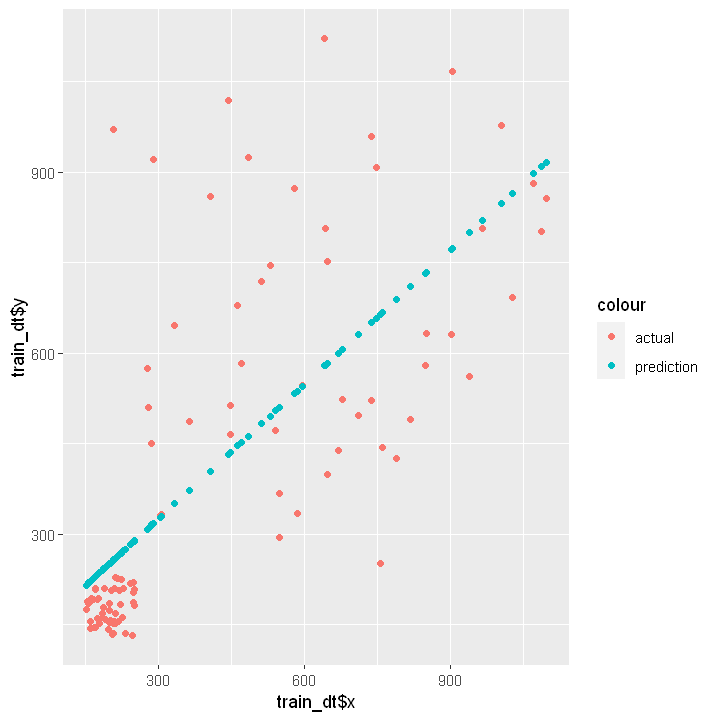

In [38]:
ggplot(train_dt,aes(x=train_dt$x)) + geom_point(aes(y=train_dt$y,col="actual")) + geom_point(aes(y=train_pred,col="prediction"))

##### Graph of Test Predictions and Actual Y Values

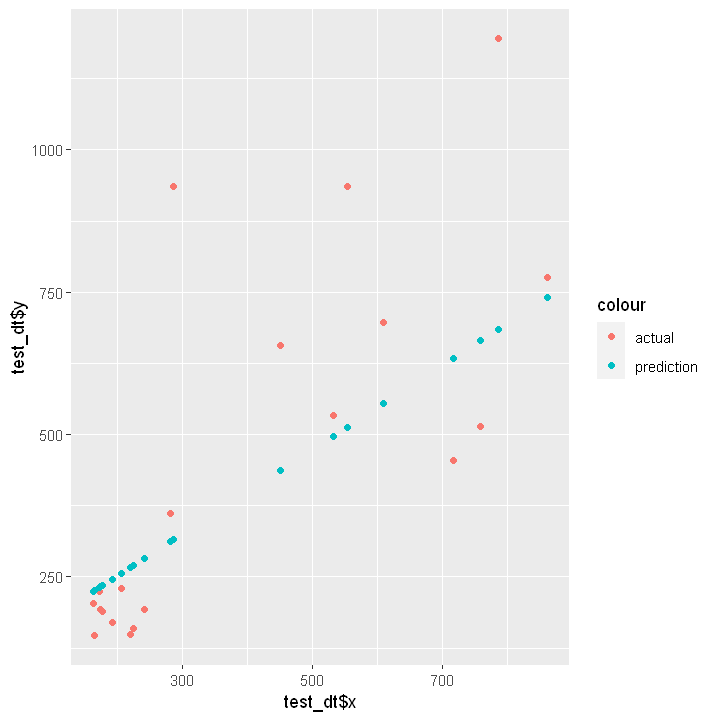

In [39]:
ggplot(test_dt,aes(x=test_dt$x)) + geom_point(aes(y=test_dt$y,col="actual")) + geom_point(aes(y=test_pred,col="prediction"))

#### b) Polynomial Regression

Again, the data is minimized with division every data point by the min value in the defined function.

In [19]:
polynomialRegression_newton <- function(e1,e2,data,w0){
    
    x_values <- data$x / min(data$x,data$y)
    y_values <- data$y / min(data$x,data$y)
    
    exprs <- expression(
      (y_values-w0-w1*x_values-w2*(x_values^2)-w3*(x_values^3))^2
    )
  
  objective_st <- function(wvec){
    w0_st <- wvec[1]
    w1_st <- wvec[2]
    w2_st <- wvec[3]
    w3_st <- wvec[4]  
    return(sum(eval(exprs,envir = list(w0=w0_st,w1=w1_st,w2=w2_st,w3=w3_st))))
  }
  k <- 0
  w <- list()
  w[[as.character(k)]] <- w0
  ctrl <- TRUE  
  
  while(ctrl==TRUE){
    hes <- get_hessian_4d(exprs,w[[as.character(k)]],y_values,x_values)
    g1  <- sum(eval(D(exprs,"w0"),envir = list(w0=w[[as.character(k)]][1],w1=w[[as.character(k)]][2],
                                               w2=w[[as.character(k)]][3],w3=w[[as.character(k)]][4])))
    g2  <- sum(eval(D(exprs,"w1"),envir = list(w0=w[[as.character(k)]][1],w1=w[[as.character(k)]][2],
                                               w2=w[[as.character(k)]][3],w3=w[[as.character(k)]][4])))
    g3  <- sum(eval(D(exprs,"w2"),envir = list(w0=w[[as.character(k)]][1],w1=w[[as.character(k)]][2],
                                               w2=w[[as.character(k)]][3],w3=w[[as.character(k)]][4])))
    g4  <- sum(eval(D(exprs,"w3"),envir = list(w0=w[[as.character(k)]][1],w1=w[[as.character(k)]][2],
                                               w2=w[[as.character(k)]][3],w3=w[[as.character(k)]][4])))
    grad <- c(-g1,-g2,-g3,-g4)
    direction <- solve(hes) %*% grad  
    alpha <- argmin(objective_st,w[[as.character(k)]],e2,direction)
    w[[as.character(k+1)]] <- w[[as.character(k)]]+(alpha*direction)
    k <- k + 1 
    if(norm_vec(grad)<e1){
      ctrl <- FALSE
    }
  }
  w0 <- w[[length(w)]][1]*min(data$x,data$y)
  w1 <- w[[length(w)]][2]
  w2 <- w[[length(w)]][3]/min(data$x,data$y)
  w3 <- w[[length(w)]][4]/(min(data$x,data$y)^2) 
  it <- length(w)  
  return(data.table("Number of iterations"=it,"w0"=w0,"w1"=w1,"w2"=w2,"w3"=w3))  
}

In [20]:
res_b <- polynomialRegression_newton(0.00001,0.00001,train_dt,c(1,1,1,1))

In [21]:
res_b

Number of iterations,w0,w1,w2,w3
<int>,<dbl>,<dbl>,<dbl>,<dbl>
375,-561.0178,5.357579,-0.008001828,3.951136e-06


The best "w" parameters are found after 325 iterations. The formula of the polynomial regression is y=-561.02+(5.35x)-(0.008x^2)+(0.0000039x^3). Again, results are compared to "lm" function. The results are again very close.

In [22]:
model_pm <- lm(y~x + I(x^2) + I(x^3),train_dt)
model_pm


Call:
lm(formula = y ~ x + I(x^2) + I(x^3), data = train_dt)

Coefficients:
(Intercept)            x       I(x^2)       I(x^3)  
 -5.610e+02    5.358e+00   -8.002e-03    3.951e-06  


In [23]:
train_sse_b <- sum(eval(objective2,envir = list(w0=res_b$w0,w1=res_b$w1,w2=res_b$w2,w3=res_b$w3)))
test_mse_b <-  sum(eval(objective2_test,envir = list(w0=res_b$w0,w1=res_b$w1,w2=res_b$w2,w3=res_b$w3)))/length(x_test)
test_s2_b <- sum((test_mse_b-eval(objective2_test,envir = list(w0=res_b$w0,w1=res_b$w1,w2=res_b$w2,w3=res_b$w3)))^2)/(length(x_test)-1)

In [24]:
train_sse_b

[1] 3146364

In [25]:
test_mse_b

[1] 42182.31

In [26]:
test_s2_b

[1] 8360713124

In [27]:
predict_pm <- function(x,res){
    y = res$w0 + res$w1*x + res$w2*x^2 + res$w3*x^3
    return(y)
}

In [28]:
train_pred_b <- predict_pm(train_dt$x,res_b)
test_pred_b <- predict_pm(test_dt$x,res_b)

##### Graph of Training Predictions and Actual Y Values

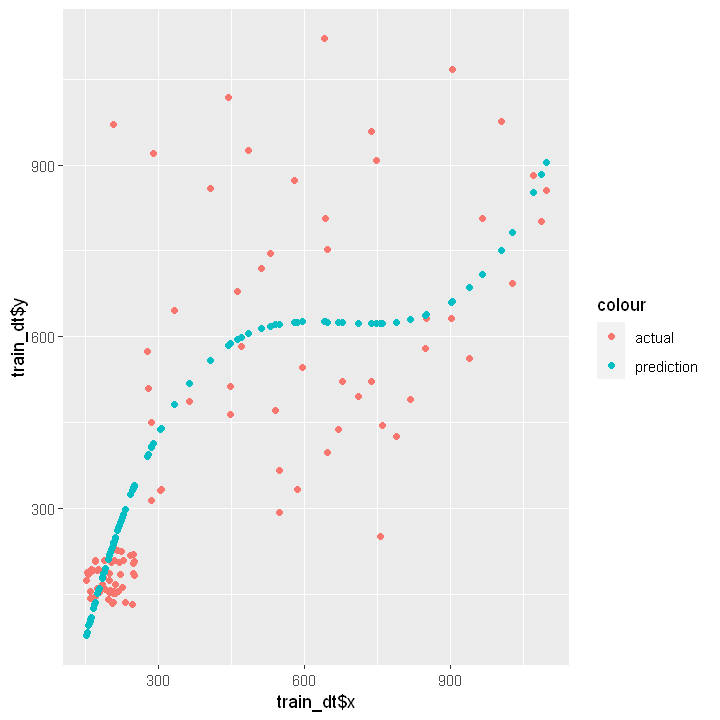

In [40]:
ggplot(train_dt,aes(x=train_dt$x)) + geom_point(aes(y=train_dt$y,col="actual")) + geom_point(aes(y=train_pred_b,col="prediction"))

##### Graph of Test Predictions and Actual Y Values

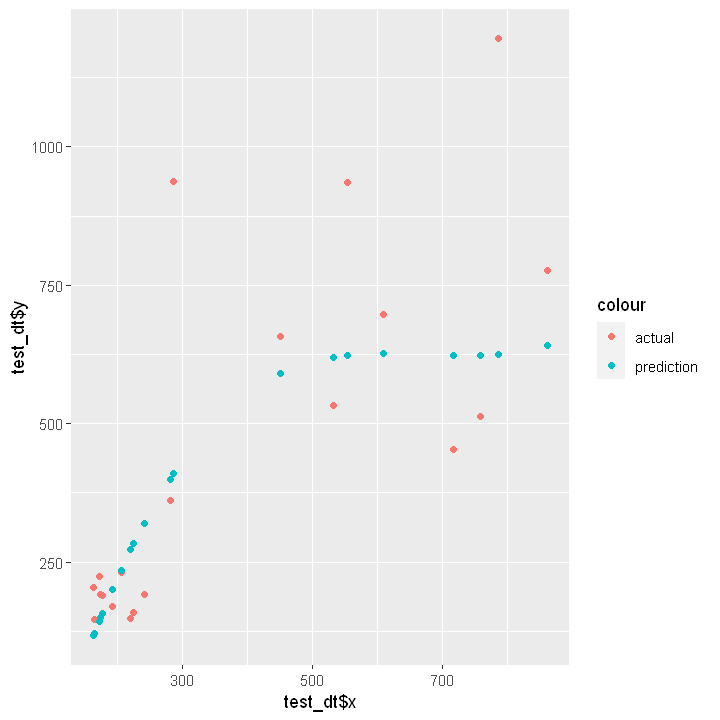

In [41]:
ggplot(test_dt,aes(x=test_dt$x)) + geom_point(aes(y=test_dt$y,col="actual")) + geom_point(aes(y=test_pred_b,col="prediction"))

#### Performance Measures LinearRegression vs PolynomialRegression

In [31]:
compare <- data.table("Model"=c("a) LinearRegression","b) PolynomialRegression"),"Training SSE"=c(train_sse_a,train_sse_b),
                      "Test MSE"=c(test_mse_a,test_mse_b),"Variance for Test MSE"=c(test_s2_a,test_s2_b))
compare

Model,Training SSE,Test MSE,Variance for Test MSE
<chr>,<dbl>,<dbl>,<dbl>
a) LinearRegression,3834771,50217.30,10655325397
b) PolynomialRegression,3146364,42182.31,8360713124
